# Reconstruction-based Prediction Demo

---

**Authors:** Riley Brady and Aaron Spring

---

This demo demonstrates the capabilities of the prediction module for a decadal prediction ensemble that is initialized off of a reconstruction. Note that we use the word "reconstruction," but this could be replaced with "hindcast" or "assimilation" among other things. This differs from the "perfect-model" approach of, e.g., the MPI decadal prediction system. For a perfect-model approach, see `perfect-model_predictability.ipynb`.


## Language

---

Language in the decadal prediction community is nuanced (see reference 3). It is important to distinguish the basic metrics of predictability for a hindcast/assimilation-based system. What are we comparing the actual DPLE to?

`predictability` : The DPLE ensemble mean correlated with the hindcast. The DPLE was initialized from the hindcast, but is integrated forward as a freely coupled model. This correlation coefficient (at various leads) communicates the *potential* for the climate system to be predicted. Note that one can also correlate an uninitialized ensemble (e.g., the CESM-LENS) to the hindcast to see how well an initialized ensemble does relative to an uninitialized one.

`skill` : The DPLE ensemble mean correlated to observations. How well does the initialized ensemble do at predicting the real world?

`persistence` : The hindcast lag-correlated to itself. This is a persistence prediction, i.e., predicting that next month/year will be the same as the last. This communicates whether investment into the DPLE is even worth it. For some systems/regions, persistence is plenty skillful. 

## Outline

---


## References

---

1. **Official manuscript of the CESM-DPLE release:** Yeager, S. G., et al. "Predicting near-term changes in the Earth System: A large ensemble of initialized decadal prediction simulations using the Community Earth System Model." Bulletin of the American Meteorological Society 2018 (2018). 


2. **Applied case of the DPLE on air-sea CO$_{2}$ fluxes:** Lovenduski, N. S., Yeager, S. G., Lindsay, K., and Long, M. C.: Predicting near-term changes in ocean carbon uptake, Earth Syst. Dynam. Discuss., https://doi.org/10.5194/esd-2018-73, in review, 2018. 


3. **Broad overview of decadal climate prediction and terminology:** Meehl, Gerald A., et al. "Decadal climate prediction: an update from the trenches." Bulletin of the American Meteorological Society 95.2 (2014): 243-267.

In [1]:
import numpy as np
import xarray as xr
from climpred.stats import xr_rm_trend, xr_corr
from climpred.prediction import (compute_reference, compute_persistence,
                                 xr_predictability_horizon)
import proplot as plot # Nice viz package
import matplotlib.pyplot as plt 
plot.nbsetup()

For this demo, I'm using `proplot` from https://github.com/lukelbd/proplot. If you're compiling this notebook on your own, you need to run `plot.install_fonts()` and then restart your notebook.

# Load and process data

---

`esmtools` contains a folder with post-processed sample data for MPI and CESM ensembles. To avoid supplying massive files, these are all computed as global (area-weighted) averages of SST at annual resolution.

---

## Reconstruction

---

The CESM-DPLE (Community Earth System Model-Decadal Prediction Large Ensemble) is initialized from a forced ocean sea-ice (FOSI) hindcast. This hindcast mainly uses CORE winds (i.e., a data atmosphere), with active (or modeled) ocean and sea ice components. It has been shown to reasonably reproduce historical ocean conditions, including El Niño events.

The hindcast output is provided at monthly resolution, but for the purpose of this demo, we will just look at annual means.

In [2]:
def _load_hindcast():
    hind = xr.open_dataset('../sample_data/prediction/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.SST.024901-031612.nc')
    hind = hind.drop(['z_t', 'time_bound']) # unneeded variables
    hind = hind.groupby('time.year').mean('time') # resample to annual means
    hind = hind.sel(year=slice(1955,2015))     # Same timeframe as dple
    hind = hind.rename({'year': 'initialization'}) # corresponds to language used in package
    hind = hind['SST']
    hind.name = 'reconstruction'
    return hind

In [3]:
hind = _load_hindcast()

The hindcast comes out as raw output, but we want to compare it directly to the anomalies provided by the DPLE. For annual averages, we just subtract the mean of the simulation. For monthly output, we have to remove monthly climatologies.

In [4]:
# The climatology for the DPLE was computed over 1964-2014 so we should
# generate our anomalies with the same window.
hind = hind - hind.sel(initialization=slice(1964, 2014)).mean('initialization')

## CESM Decadal Prediction Large Ensemble

---

Here, we load in the actual initialized CESM-DPLE to compute prediction metrics with (see intro to notebook).

In [5]:
def _load_dple():
    dple = xr.open_dataset('../sample_data/prediction/CESM-DP-LE.SST.annmean.anom.nc') \
             .rename({'anom': 'SST'})
    # Renames to standards expected in this package. This might be incorporated as
    # a function, although it's such minimal processing that it should be up to the
    # user.
    dple = dple.rename({'S':'initialization','M':'member','L':'time'})
    dple = dple.sel(initialization=slice(1955, 2015))
    return dple

In [6]:
dple = _load_dple()

In [7]:
dple.info()
dple = dple['SST'] # easier to work with DataArray since we don't have other variables
dple.name = 'initialized'

xarray.Dataset {
dimensions:
	initialization = 61 ;
	member = 40 ;
	time = 10 ;

variables:
	float32 SST(initialization, time, member) ;
	int32 initialization(initialization) ;
		initialization:long_name = ensemble ;
		initialization:description = historical year corresponding to forecast year 1 ;
		initialization:example = S=1955 for forecasts initialized on November 1 1954 ;
	int32 member(member) ;
		member:long_name = ensemble member ;
	int32 time(time) ;
		time:long_name = forecast year ;

// global attributes:
}

## CESM Large Ensemble

---

This is the uninitialized companion ensemble to the Decadal Prediction Ensemble. Here we have an ensemble (40 members) of simulations that are generated from minor perturbations to the initial conditions of one member in 1920.

This differs from the CESM-DPLE, as it is only initialized in 1920 and never again. It differs from FOSI, as it is a freely running ESM, *i.e.,* it is not being nudged/assimilated/forced by any data products.

**Reference:**

Kay, J. E., et al. "The Community Earth System Model (CESM) large ensemble project: A community resource for studying climate change in the presence of internal climate variability." Bulletin of the American Meteorological Society 96.8 (2015): 1333-1349.

In [8]:
cesmLE = xr.open_dataarray('../sample_data/prediction/' +
                           'CESM-LE.global_mean.SST.1955-2015.nc') \
           .rename({'time': 'initialization'})
# remove mean to generate anomaly like other
cesmLE = cesmLE - cesmLE.sel(initialization=slice(1964, 2014)).mean('initialization')
cesmLE.name = 'uninitialized'

## ERSSTv4 Observations

---

It is useful to compare the DPLE to observations to get a sense of actual skill. When we correlate the DPLE with the FOSI, we get a sense of its potential to predict the Earth system ("potential predictability"), if the initial conditions and model equations were perfect, and the resolution sufficiently fine. If we correlate to ERSST, we get actual prediction skill.

**Reference**:

https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version4/

In [9]:
data = xr.open_dataarray('../sample_data/prediction/ERSSTv4.global.mean.nc')
data = data - data.sel(year=slice(1964, 2014)).mean('year')
# To align with package conventions
data = data.rename({'year': 'initialization'})
data.name = 'data'

# High-level view of CESM-DPLE for Global SSTs

---

To get the user comfortable with what a DPLE looks like, we provide some simple plots to look at the structure of global SSTs in CESM-DPLE. 

In [10]:
dple_mean = dple.mean('member')

## Ensemble Mean View

---

By taking the ensemble mean across all 40 members, we get a sense of what the best prediction is from the ensemble. This is like the thick black line on a spaghetti plot of individual hurricane forecasts. Note that we haven't detrended yet, so you will see the SST warming trend from 1955-2015.

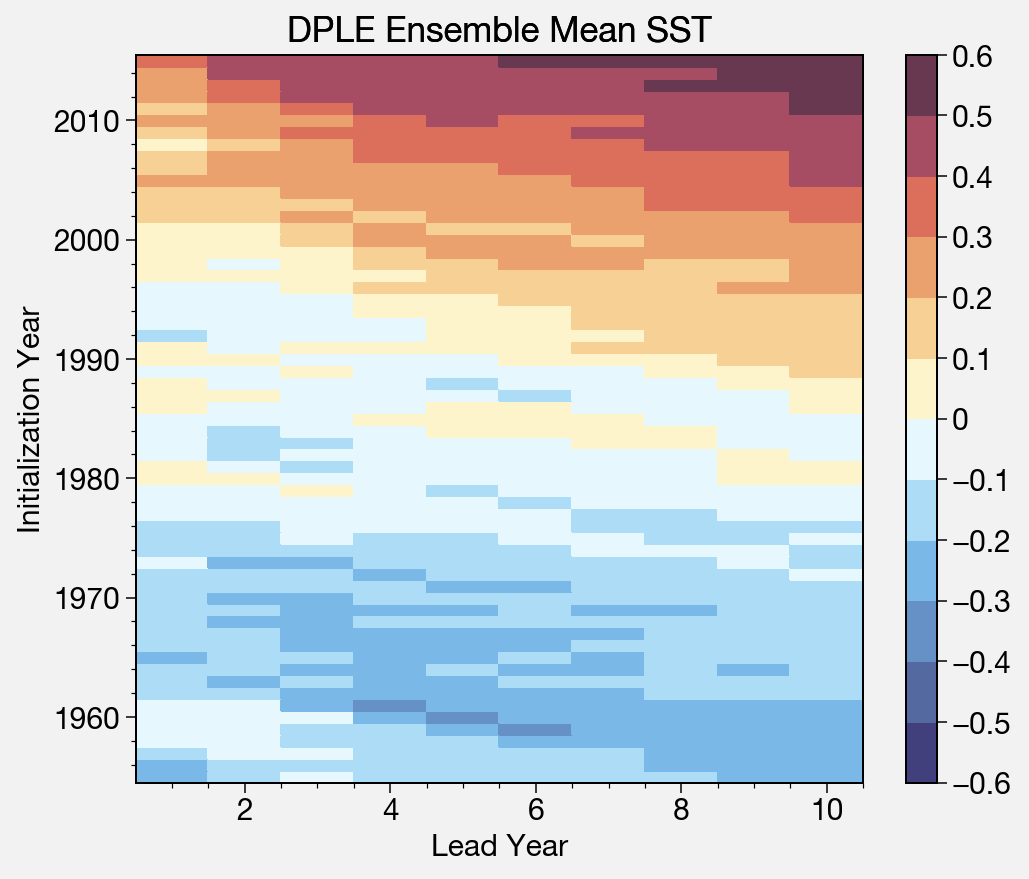

In [11]:
plot.rc.small = 12
plot.rc.large = 14
f, ax = plot.subplots(axwidth=4, aspect=1, rightpanel=True)
m = ax.pcolormesh(dple_mean.time, dple_mean.initialization, dple_mean,
                  levels=plot.arange(-0.6, 0.6, 0.1), cmap="IceFire")
cb = f.rightpanel.colorbar(m)
ax.format(xlabel='Lead Year', ylabel='Initialization Year', 
          title='DPLE Ensemble Mean SST')
cb.ax.tick_params(labelsize=12)

## Initialized Predictions

---

The whole point of CESM-DPLE is that the ensemble is initialized with "data" from the FOSI every single year and then run forward in a coupled ESM. The question this begs is, how well can a freely coupled ESM reproduce the hindcast?

Here is a look at what the spread of ensemble members looks like at a few initialization points. The thin pink lines are the individual 40 members, the dark pink line is the ensemble mean, and the black line is the FOSI that is trying to be replicated by CESM-DPLE.

**NOTE**: You might notice that the CESM-DPLE starts at a point slightly different than the FOSI. This is because, per protocal, the CESM-DPLE was initialized in November of the preceding year, so it is slightly different than the annual means from the FOSI.

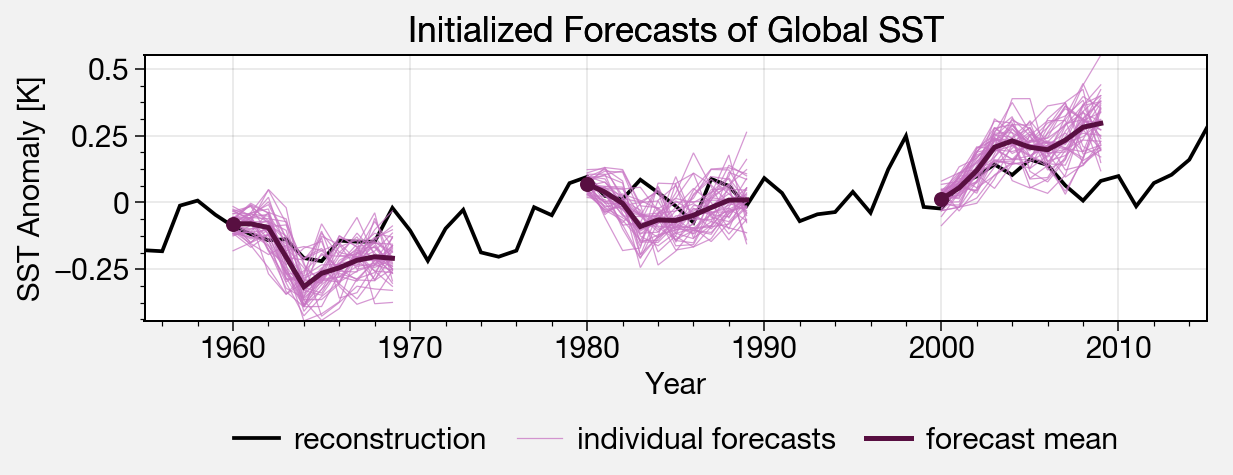

In [12]:
plot.rc.small = 12
plot.rc.large = 14

f, ax = plot.subplots(axwidth=6, aspect=4, bottomlegend=True)
r = ax.plot(hind.initialization, hind, linewidth=1.5, color='k', label='reconstruction')
init_years = [1960, 1980, 2000]
for iy in init_years:
    case = dple.sel(initialization=iy)
    case['time'] = np.arange(iy, iy+10)
    f = ax.plot(case.time, case, color='orchid', linewidth=0.5, alpha=0.75,
                label='individual forecasts')
    fm = ax.plot(case.time, case.mean('member'), linewidth=2, color='plum',
                 label='forecast mean', zorder=4)
    ax.plot(iy, case.isel(time=0).mean('member'), 'o', markersize=6,
            color='plum')

ax.format(xlabel='Year', ylabel='SST Anomaly [K]',
          title='Initialized Forecasts of Global SST')
plt.legend([r[0], f[0], fm[0]])    

# Basic Prediction Metrics

---

Now, let's get into some predictability metrics (see intro for definitions). We aren't doing anything too advanced here; we are just correlating anomalies (trended and detrended) with the FOSI reference to get a sense of the skill of our predictions.

---

**NOTE**: For each of the metrics, we will be plotting a version that retains the long-term warming trend and a version that is detrended. The latter is much more common and important in the prediction community: can we predict anomalies relative to the secular trend that are mostly produced by random fluctuations in the climate system?

In [13]:
hind_dt = xr_rm_trend(hind, dim='initialization')
hind_dt.name = 'reconstruction' # naming for easier plotting later
dple_dt = xr_rm_trend(dple_mean, dim='initialization')
dple_dt.name = 'initialized'
cesmLE_dt = xr_rm_trend(cesmLE, dim='initialization')
cesmLE_dt.name = 'uninitialized'
data_dt = xr_rm_trend(data, dim='initialization')
data_dt.name = 'data'

## Ensemble Mean Plots

---

First, let's look at the ensemble mean (lead year 1 for CESM-DPLE) of each of our products: the initialized prediction ensemble, the uninitialized ensemble, the reconstruction, and our actual SST data.

Here you see the power of the initialized ensemble. Compare the bottom panel's red line to the aqua line.

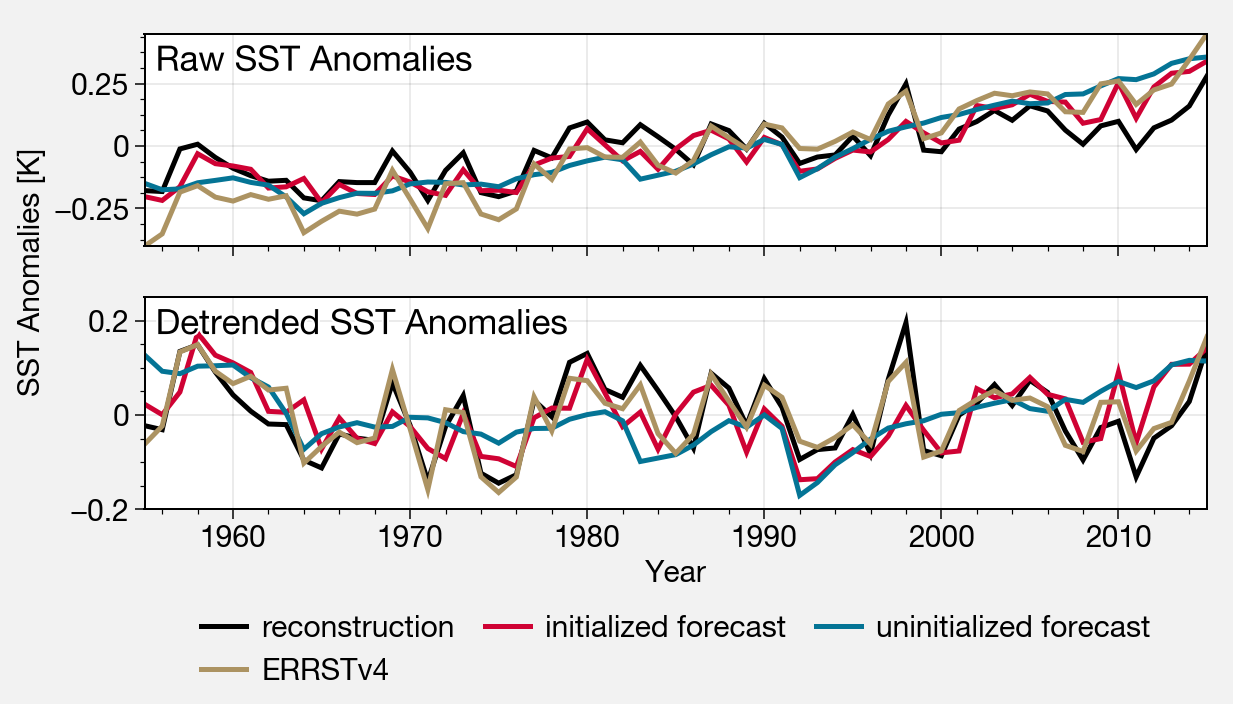

In [14]:
plot.rc.small = 12
plot.rc.large = 14

f, ax = plot.subplots(nrows=2, axwidth=6, aspect=5,
                      bottomlegend=True, tight=True)

"""
TOP PANEL:
Ensemble means for all four products without removing the trend.
"""
r = ax[0].plot(hind.initialization, hind, color='k', linewidth=2, label='reconstruction')
i = ax[0].plot(dple.initialization, dple_mean.isel(time=0), linewidth=2, color='cherry',
        label='initialized forecast')
u = ax[0].plot(cesmLE.initialization, cesmLE, color='sea blue', linewidth=2,
           label='uninitialized forecast')
d = ax[0].plot(data.initialization, data, color='dark beige', linewidth=2,
           label='ERRSTv4')

"""
BOTTOM PANEL:
Ensemble means for all four products after removing a linear trend.
"""
ax[1].plot(hind_dt.initialization, hind_dt, color='k', linewidth=2)
ax[1].plot(dple_dt.initialization, dple_dt.isel(time=0), color='cherry', linewidth=2)
ax[1].plot(cesmLE_dt.initialization, cesmLE_dt, color='sea blue', linewidth=2)
ax[1].plot(data_dt.initialization, data_dt, color='dark beige', linewidth=2)

plt.legend([r[0], i[0], u[0], d[0]])
ax.format(rc_kw={'figure.titlesize': 12}, ylabel='SST Anomalies [K]',
          xlabel='Year')
ax[0].format(title='Raw SST Anomalies', titlepos='li')
ax[1].format(title='Detrended SST Anomalies', titlepos='li', ylim=[-0.2,0.25])

## Potential Predictability and Skill

---

Now we can leverage the simulations and data we have to compute potential predictability (in reference to the FOSI) and skill (in reference to ERSST)

In [15]:
def _compute_skills(hind, dple, cesmLE, data, predType='potential'):
    """
    Quick function to compute the predictability/skill given all
    four datasets.
    
    predType should either be 'potential' for potential predictability
    or 'skill' for true prediction skill.
    """
    if 'member' in dple.dims:
        dple = dple.mean('member')
    if predType == 'potential':
        # Initialized ensemble predictability
        ip, p_values = compute_reference(dple, hind, return_p=True)
        # Uninitialized ensemble predictability
        up = xr_corr(cesmLE, hind, dim='initialization')
        up = xr.DataArray([np.asarray(up)]*10, dims='time') # DP protocol
        # Persistence forecast
        persist = compute_persistence(dple, hind, 10)
        # Horizon computation
        ph = xr_predictability_horizon(ip, persist, p_values=p_values,
                                       N=61)
    elif predType == 'skill':
        ip, p_values = compute_reference(dple, data, return_p=True)
        up = xr_corr(cesmLE, data, dim='initialization')
        up = xr.DataArray([np.asarray(up)]*10, dims='time') # DP protocol
        persist = compute_persistence(dple, data, 10)
        ph = xr_predictability_horizon(ip, persist, p_values=p_values,
                                       N=61)
    return ip, up, persist, ph


def _plot_skill(ax, result, color='k', linestyle='-', marker='o', 
                markersize=6, linewidth=2, **kwargs):
    """
    Quick function to plot results of predictability analysis.
    """
    if 'lead time' not in result.coords:
        N = len(result)
        result['time'] = np.arange(1, N+1)
    p = ax.plot(result['time'], result, color=color, linestyle=linestyle, 
                marker=marker, markersize=markersize, linewidth=linewidth, 
                **kwargs)
    return p

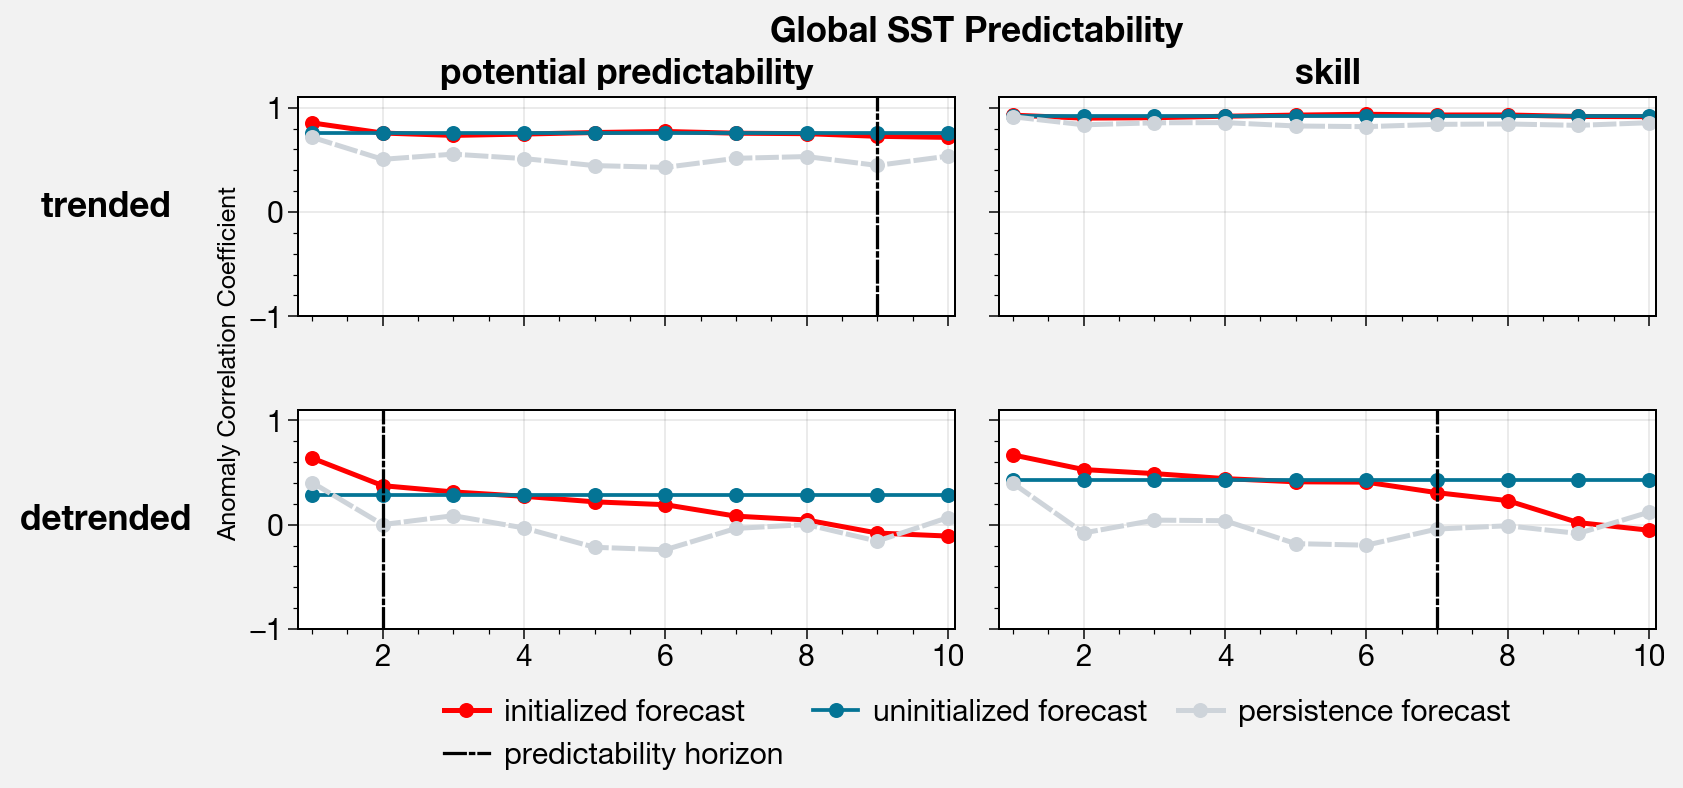

In [16]:
plot.rc.small = 12
plot.rc.large = 14

f, axs = plot.subplots(nrows=2, ncols=2, axwidth=4, aspect=3, bottomlegend=True,
                       hspace=0.4, left=1)
trended_set = xr.merge([hind, dple, cesmLE, data])
detrended_set = xr.merge([hind_dt, dple_dt, cesmLE_dt, data_dt])
titles = ['trended predictability', 'trended skill',
          'detrended predictability', 'detrended skill']

for ax, predType, ds, title in zip(axs, ['potential', 'skill', 'potential', 'skill'],
                             [trended_set, trended_set, detrended_set, 
                              detrended_set], titles):
    ip, up, persist, ph = _compute_skills(ds.reconstruction, ds.initialized,
                                      ds.uninitialized, ds.data, 
                                      predType=predType)
    i = _plot_skill(ax, ip, color='r', label='initialized forecast')
    u = _plot_skill(ax, up, color='sea blue', linewidth=1.5,
                    label='uninitialized forecast')
    p = _plot_skill(ax, persist, color='gray4', linestyle='--',
                    label='persistence forecast')
    p2 = ax.axvline(x=ph, color='k', linestyle='-.', 
                    label='predictability horizon')


axs.format(ylim=[-1,1.1], xlim=[0.8, 10.1], rowlabels=['trended', 'detrended'],
           ylabel='Anomaly Correlation Coefficient', ylabel_kw=dict(fontsize=10),
           collabels=['potential predictability', 'skill'],
           suptitle='Global SST Predictability')
plt.legend([i[0], u[0], p[0], p2])